# 画像処理検討ノート

In [1]:
from __future__ import unicode_literals
from __future__ import print_function
import sys
import os
import math
import random
import datetime as dt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import json
import scipy.ndimage
import PIL.Image

import chainer
import chainer.functions as F
import chainer.links as L

%reload_ext autoreload
%autoreload 2

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', 'lib'))
from image_process import *

sys.path.append(os.path.join(os.path.dirname(os.path.abspath('__file__')), '..', 'cmd', 'yolo', 'lib'))
from bounding_box import *

In [3]:
sys.version

'2.7.13 |Anaconda 4.3.0 (x86_64)| (default, Dec 20 2016, 23:05:08) \n[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]'

In [4]:
cv2.__version__

'3.1.0'

In [5]:
chainer.__version__

'1.22.0'

## ダミー背景の作成

In [6]:
bg_color_image_path = '/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/2/13/color.bmp'
bg_label_image_path = '/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/mask_label/single/2/13/label.bmp'

In [7]:
bg_color_image = cv2.imread(bg_color_image_path)
bg_label_image = cv2.imread(bg_label_image_path, 0)

In [8]:
bg_label_image.shape[:2]

(960, 1280)

In [9]:
_, _, stats, centroids = cv2.connectedComponentsWithStats(bg_label_image)
stats, centroids

for stat, centroid in zip(stats, centroids):
    region_x, region_y, region_w, region_h, _ = stat[0], stat[1], stat[2], stat[3], stat[4]
    centor_x, centor_y = int(math.floor(centroid[1])), int(math.floor(centroid[0]))
    if region_w * region_h <= (2 * bg_label_image.shape[1]):
        continue
    if region_w * region_h >= (bg_label_image.shape[0] * bg_label_image.shape[1] * 0.95):
        continue
    break

region_x, region_y, region_w, region_h

(712, 676, 124, 188)

In [10]:
240 * 180

43200

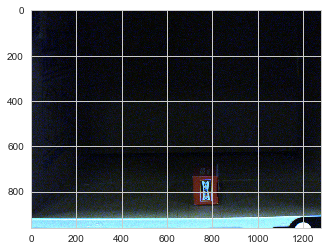

In [11]:
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(bg_color_image, cv2.COLOR_BGR2RGB))

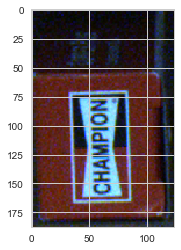

In [12]:
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(bg_color_image[676:676+188,712:712+124], cv2.COLOR_BGR2RGB))

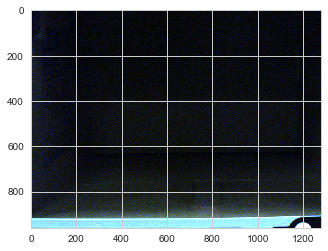

In [13]:
bg_image = bg_color_image.copy()
bg_image[676:676+188,712:712+124] = bg_color_image[676:676+188,712+124:712+124+124]
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGB))

## オブジェクトの抽出

In [14]:
with open(os.path.join('..', 'cache', 'single_catalog.json'), 'r') as fp:
    catalog = json.load(fp)
    
train_dataset = filter(lambda item: item['bounding_boxes'] != [], catalog['dataset'])
len(train_dataset)

749

In [15]:
ix = np.random.randint(0,750)
print(ix)
dataset = train_dataset[ix]

218


In [16]:
dataset

{u'bounding_boxes': [{u'class': u'16',
   u'height': u'511',
   u'width': u'522',
   u'x': u'40',
   u'y': u'336'}],
 u'classes': [u'16'],
 u'color_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/16/24/color.bmp',
 u'depth_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/16/24/depth.bmp.bmp',
 u'label_image_path': u'/Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/mask_label/single/16/24/label.bmp',
 u'pattern_id': u'24'}

In [17]:
color_image_path = dataset['color_image_path']
label_image_path = dataset['label_image_path']
bbox = dataset['bounding_boxes'][0]

bbox

{u'class': u'16',
 u'height': u'511',
 u'width': u'522',
 u'x': u'40',
 u'y': u'336'}

In [18]:
with open(os.path.join('..', 'lib', 'item_table.csv')) as fp:
    df_item_table = pd.read_csv(fp).set_index('class')

df_item_table

,r,g,b
class,,,
0,0,0,0
1,128,0,0
2,255,0,0
3,0,128,0
4,128,128,0
5,255,128,0
6,0,255,0
7,128,255,0
8,255,255,0


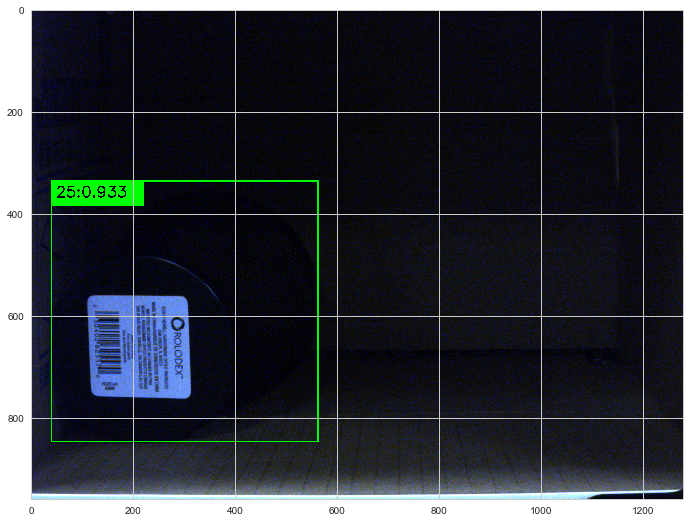

In [19]:
color_image = cv2.imread(color_image_path)

x = int(bbox['x'])
y = int(bbox['y'])
w = int(bbox['width'])
h = int(bbox['height'])

cv2.rectangle(color_image, (x, y), (x+w, y+h), [0,255,0], thickness=2)
cv2.rectangle(color_image, (x, y), (x+180, y+48), [0,255,0], thickness=-1)
cv2.putText(color_image, '25:0.933', (x+8, y+32), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), thickness=2)

fig, axes = plt.subplots(1,1, figsize=(12,9))
axes.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))

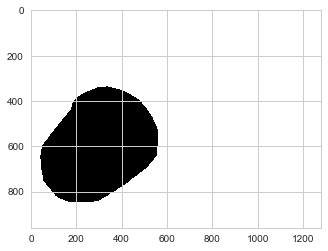

In [20]:
label_image = cv2.imread(label_image_path, 0)
fig, axes = plt.subplots(1,1)
axes.imshow(label_image)

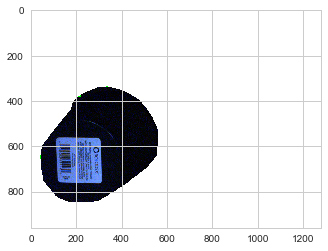

In [21]:
roi_image = cv2.bitwise_and(color_image, color_image, mask=label_image)
roi_image = cv2.cvtColor(roi_image, cv2.COLOR_BGR2BGRA)
roi_image[label_image == 0, 3] = 0

fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGRA2RGBA))

<Box x:40 y:336 w:522 h:511 c:0 o:1.0>


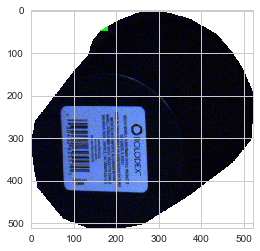

In [22]:
box = Box(
    x=int(bbox['x']),
    y=int(bbox['y']),
    width=int(bbox['width']),
    height=int(bbox['height'])
)
print(box)

obj_image = roi_image[box.top:box.bottom,box.left:box.right]
fig, axes = plt.subplots(1,1)
axes.imshow(cv2.cvtColor(obj_image, cv2.COLOR_BGRA2RGBA))

In [23]:
def rotate_image(image, angle):
    return scipy.ndimage.rotate(image, angle, reshape=True)

def scale_image(image, scale):
    h, w = image.shape[:2]
    return cv2.resize(image, (int(w*scale), int(h*scale)))

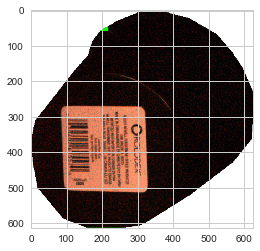

In [24]:
obj_image = scale_image(obj_image, 1.2)
fig, axes = plt.subplots(1,1)
axes.imshow(obj_image)

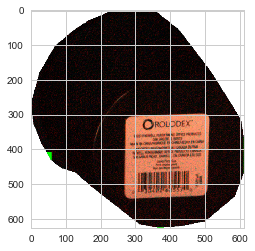

In [25]:
obj_image = rotate_image(obj_image, 90)
fig, axes = plt.subplots(1,1)
axes.imshow(obj_image)

## オブジェクトをダミー背景に重畳

230 259 613 626 1280 960


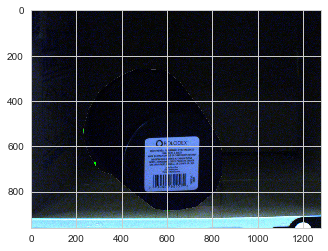

In [26]:
new_pimage = PIL.Image.fromarray(cv2.cvtColor(bg_image, cv2.COLOR_BGR2RGBA))
obj_pimage = PIL.Image.fromarray(cv2.cvtColor(obj_image, cv2.COLOR_BGRA2RGBA))

oh, ow = obj_image.shape[:2]
bh, bw = bg_image.shape[:2]
ox = int((bw-ow)/2 + random.uniform(-0.4*(bw-ow), 0.4*(bw-ow)))
oy = int((bh-oh)   - max(random.uniform(0.1*(bh-oh), 0.3*(bh-oh)), 0.05*bh))
print(ox, oy, ow, oh, bw, bh)

new_pimage.paste(obj_pimage, box=(ox, oy), mask=obj_pimage)

fig, axes = plt.subplots(1,1)
axes.imshow(new_pimage)

In [27]:
new_image = cv2.cvtColor(np.asarray(new_pimage), cv2.COLOR_RGBA2BGR)

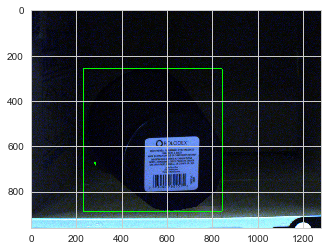

In [28]:
new_image2 = cv2.rectangle(new_image, (ox, oy), (ox+ow, oy+oh), [0,255,0], thickness=3)

fig, axes = plt.subplots(1, 1)
axes.imshow(cv2.cvtColor(new_image2, cv2.COLOR_BGR2RGB))

In [29]:
random.uniform(-36, 36)

1.532138088660119

In [30]:
random.randint(0,360)

48

In [31]:
def load_class_color_table():
    path = os.path.join(os.path.dirname(os.path.abspath('__file__')),
                        '..', 'lib', 'item_table.csv')
    with open(path, 'r') as fp:
        df = pd.read_csv(fp, encoding='cp932', index_col=['class'])
    return df

In [32]:
df_class_color_table = load_class_color_table()
df_class_color_table

,r,g,b
class,,,
0,0,0,0
1,128,0,0
2,255,0,0
3,0,128,0
4,128,128,0
5,255,128,0
6,0,255,0
7,128,255,0
8,255,255,0


In [33]:
def find_class_by_color(df, r=0, g=0, b=0):
    indexer = (df['r'] == r) & (df['g'] == g) & (df['b'] == b)
    return int(df_class_color_table[indexer].index[0])

In [34]:
find_class_by_color(df_class_color_table, 128, 128, 255)

22

In [35]:
df_class_color_table.ix[22,'r']

128

In [36]:
def find_color_by_class(df, clazz=0):
    return int(df.ix[clazz,'r']), int(df.ix[clazz,'g']), int(df.ix[clazz,'b'])

In [37]:
find_color_by_class(df_class_color_table, 22)

(128, 128, 255)

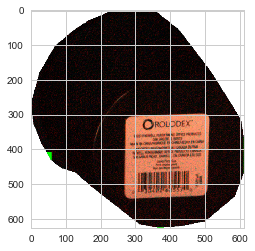

In [38]:
plt.imshow(obj_image)

In [39]:
obj_image[:,:,3] != 0

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ..., 
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], dtype=bool)

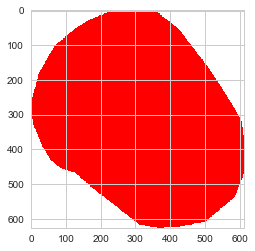

In [40]:
label_image = obj_image.copy()
label_image[obj_image[:,:,3] > 0] = [255,0,0,255]
plt.imshow(label_image)

In [41]:
bg_image.shape

(960, 1280, 3)

In [42]:
black_image = np.tile(0, bg_image.shape).astype(np.uint8)

In [43]:
'2'.zfill(2)

u'02'

In [44]:
os.path.exists('..')

True

In [45]:
cv2.resize(bg_image, (640, 480))

array([[[ 23,   8,   9],
        [ 20,   5,   7],
        [  1,   4,   8],
        ..., 
        [  1,   2,  13],
        [  8,   3,   8],
        [  1,   4,   8]],

       [[  2,   8,  10],
        [ 48,   6,   7],
        [ 38,   8,   6],
        ..., 
        [  0,   2,  13],
        [  0,   8,   7],
        [  9,   3,  10]],

       [[  7,   5,  13],
        [  4,   6,   9],
        [ 26,  13,   7],
        ..., 
        [ 27,   4,   6],
        [  1,  10,   8],
        [  0,   6,   8]],

       ..., 
       [[232, 240, 158],
        [249, 227, 146],
        [255, 212, 145],
        ..., 
        [ 54,   7,   5],
        [ 22,  11,   7],
        [ 33,  15,   5]],

       [[254, 221, 150],
        [251, 221, 143],
        [254, 220, 140],
        ..., 
        [ 17,  11,  11],
        [ 23,  14,   6],
        [ 48,  12,   4]],

       [[253, 195, 134],
        [253, 195, 127],
        [225, 195, 124],
        ..., 
        [ 35,  16,   5],
        [  1,   7,   7],
        [ 12,  10,

In [46]:
class Item():
    def __init__(self, item):
        self.color_image_path = item['color_image_path']
        self.label_image_path = item['label_image_path']
        self.clazz = item['classes'][0]
        self.bounding_box = Box(
            x=int(item['bounding_boxes'][0]['x']),
            y=int(item['bounding_boxes'][0]['y']),
            width=int(item['bounding_boxes'][0]['width']),
            height=int(item['bounding_boxes'][0]['height']),
            clazz=int(item['bounding_boxes'][0]['class'])
        )

In [47]:
items = [Item(item) for item in train_dataset]

In [48]:
# サンプリング数を決定 (2〜4)
n_sampling = np.random.randint(2, 5)

n_sampling

3

In [79]:
obj_images = []
for i in range(0, n_sampling):
    item = np.random.choice(items)
    sys.stdout.write('\r%d process %s' % (0, item.color_image_path))
    sys.stdout.flush()
    obj_image = extract_object_image(
                    item.color_image_path, item.label_image_path, item.bounding_box)
    obj_images.append(obj_image)

obj_image_shapes = [img.shape for img in obj_images]
obj_image_shapes

0 process /Users/uents/repos/github.com/uents/chainer-playground/dl-course/contest/APC/Single/Single/6/7/color.bmpmp

[(458, 509, 4), (561, 720, 4), (594, 684, 4)]

In [80]:
reduce(lambda x,y: x + y, [s[0] for s in obj_image_shapes])

1613